In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp

from scipy.interpolate import interp1d

## `Pyomo`

* `Pyomo` is a collection of Python software packages for formulating optimization models
* Supports multiple solvers, including:
* `IPOPT`, short for "Interior Point OPTimizer, pronounced I-P-Opt", is a software library for large scale nonlinear optimization of continuous systems.

### `Using a collocation matrix as constraints`

In [2]:
import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

### du_dt = -u

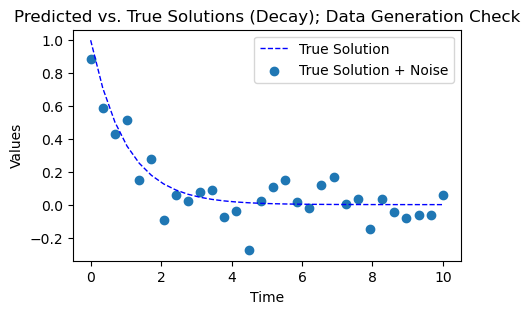

In [3]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 30
noise_level = 0.1
ode_type = "decay"
params = {"c": 1}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = jnp.array([1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))

#--------------------------------------------VERIFY DATA--------------------------------------------#
plt.figure(figsize=(5, 3))

plt.subplot(1, 1, 1)  
plt.plot(t, y, 'b--', linewidth=1, label='True Solution')
plt.scatter(t, y_noisy, label='True Solution + Noise')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions (Decay); Data Generation Check')
plt.legend(loc='upper right')

In [4]:
#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, len(y_noisy)-1)

#---------------------------VARIABLE DEFINITION--------------------------#
model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)

#---------------------------INITIAL CONDITIONS---------------------------#
# model.initial_conditions = ConstraintList()
# model.initial_conditions.add(model.u[0] == 1.0)

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
model.ode_u = ConstraintList()

# for each time point, add the ODE constraint
for i in range(0, N):
    
    # remains constant
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
    
    if i == 1:
        print(f"model.u[j] type: {type(model.u[i])}")
        print(f"du_dt: {du_dt}")
        print(f"du_dt type: {type(du_dt)} \n")
        # the type of du_dt is LinearExpression
    
    model.ode_u.add(du_dt == - model.u[i])


#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    return sum((m.u[i] - y_noisy[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=pyo.minimize)
    
#---------------------------SOLVING THE MODEL--------------------------#
solver = pyo.SolverFactory('ipopt')
solver.options['tol'] = 1e-6
solver.options['bound_push'] = 1e-6
solver.options['constr_viol_tol'] = 1e-6
solver.options['max_iter'] = 1000

solver.solve(model, tee=True)

model.u[j] type: <class 'pyomo.core.base.var.VarData'>
du_dt: -0.0999999999999999*u[0] - 8.48879601400565*u[1] + 40.59999999999997*u[2] - 182.69999999999968*u[3] + 791.6999999999994*u[4] - 2968.8749999999986*u[5] + 9500.399999999987*u[6] - 26012.999999999945*u[7] + 61316.357142857014*u[8] - 125187.56249999996*u[9] + 222555.66666666672*u[10] - 345972.8999999995*u[11] + 471781.2272727263*u[12] - 565532.6250000001*u[13] + 596605.846153846*u[14] - 553991.1428571416*u[15] + 452426.09999999875*u[16] - 324349.59374999907*u[17] + 203513.47058823516*u[18] - 111277.83333333344*u[19] + 52710.55263157891*u[20] - 21460.72499999999*u[21] + 7432.285714285723*u[22] - 2159.1818181818144*u[23] + 516.3260869565202*u[24] - 98.96249999999964*u[25] + 14.615999999999952*u[26] - 1.561538461538461*u[27] + 0.10740740740740858*u[28] - 0.00357142857142859*u[29]
du_dt type: <class 'pyomo.core.expr.numeric_expr.LinearExpression'> 

Ipopt 3.14.16: tol=1e-06
bound_push=1e-06
constr_viol_tol=1e-06
max_iter=1000


****

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 30, 'Number of variables': 30, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.16\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.039877891540527344}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [5]:
#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])

print("u(t):", u_solution)

u(t): [8.88698573e-01 6.29503332e-01 4.45903926e-01 3.15852690e-01
 2.23731875e-01 1.58478789e-01 1.12257257e-01 7.95165824e-02
 5.63249724e-02 3.98973701e-02 2.82610017e-02 2.00184678e-02
 1.41799309e-02 1.00442473e-02 7.11476695e-03 5.03969160e-03
 3.56982760e-03 2.52866050e-03 1.79115763e-03 1.26875302e-03
 8.98711651e-04 6.36595635e-04 4.50927721e-04 3.19411266e-04
 2.26252539e-04 1.60264379e-04 1.13521610e-04 8.04151654e-05
 5.69323216e-05 4.09555219e-05]


u(t): [8.88698573e-01 6.29503332e-01 4.45903926e-01 3.15852690e-01
 2.23731875e-01 1.58478789e-01 1.12257257e-01 7.95165824e-02
 5.63249724e-02 3.98973701e-02 2.82610017e-02 2.00184678e-02
 1.41799309e-02 1.00442473e-02 7.11476695e-03 5.03969160e-03
 3.56982760e-03 2.52866050e-03 1.79115763e-03 1.26875302e-03
 8.98711651e-04 6.36595635e-04 4.50927721e-04 3.19411266e-04
 2.26252539e-04 1.60264379e-04 1.13521610e-04 8.04151654e-05
 5.69323216e-05 4.09555219e-05]


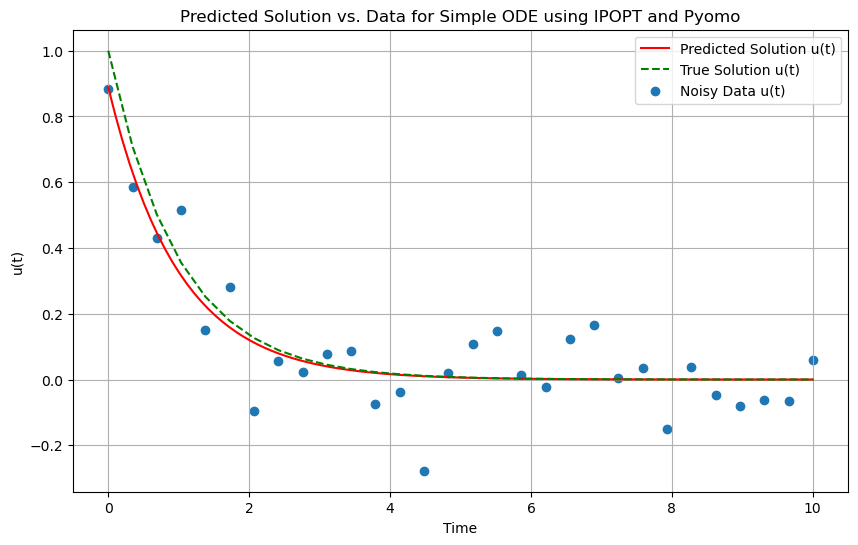

In [6]:
#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])

print("u(t):", u_solution)

#---------------------------INTERPOLATION--------------------------#
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], 100)
y_new = interp_fn(x_new)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 6))
plt.plot(x_new, y_new, 'r', label='Predicted Solution u(t)')
plt.plot(t, y, 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy, label='Noisy Data u(t)')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using IPOPT and Pyomo')
plt.grid(True)
plt.show()

### Regenerate Data; Modifying C parameter

### `model.C` - C is treated as another variable

In [12]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 100
noise_level = 0.2
ode_type = "decay"
params = {"c": 0.5}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, len(y_noisy)-1)

#---------------------------VARIABLE DEFINITION--------------------------#
model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
model.C = pyo.Var(domain=pyo.Reals, initialize=1.0) # adding c as a variable

#---------------------------INITIAL CONDITIONS---------------------------#
# model.initial_conditions = ConstraintList()
# model.initial_conditions.add(model.u[0] == 1.0)

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
model.ode_u = ConstraintList()

# for each time point, add the ODE constraint
for i in range(1, N):
    # remains constant
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
    model.ode_u.add(du_dt == - model.C * model.u[i])


#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    return sum((m.u[i] - y_noisy[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=pyo.minimize)
    
#---------------------------SOLVING THE MODEL--------------------------#
solver = pyo.SolverFactory('ipopt')
# solver.options['tol'] = 1e-6
# solver.options['bound_push'] = 1e-6
# solver.options['constr_viol_tol'] = 1e-6
solver.options['max_iter'] = 1000

solver.solve(model, tee=True)

Ipopt 3.14.16: max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     9999
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      199

Total number of variables............................:      101
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       9

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 99, 'Number of variables': 101, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.16\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.029393911361694336}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

0.5507


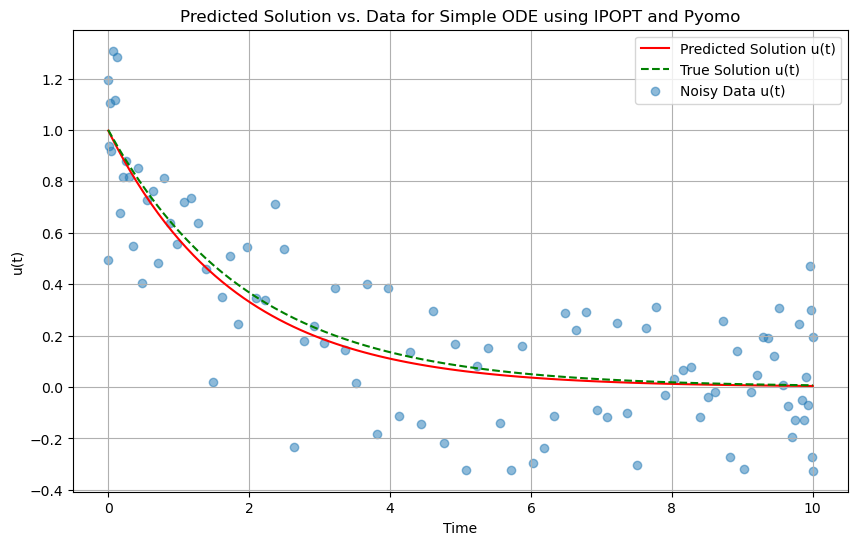

In [13]:
#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
print(f"{value(model.C):.4f}")

#---------------------------INTERPOLATION--------------------------#
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], 100)
y_new = interp_fn(x_new)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 6))
plt.plot(x_new, y_new, 'r', label='Predicted Solution u(t)')
plt.plot(t, y, 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using IPOPT and Pyomo')
plt.grid(True)
plt.show()

# `jaxopt`

In [276]:
import jaxopt

In [288]:
# regularizaton parameter
lambda_reg = 0.2
penalty_weight = 100

#----------------------------------------DATA PARAMS---------------------------------------------#
N = 100
noise_level = 0.2
ode_type = "decay"
params = {"c": 0.5}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([1.0])

#----------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

y_noisy = jnp.squeeze(y_noisy)

#----------------------------------------COLLOCATION MATRIX---------------------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = jnp.array(D)

#--------------------------------------------OBJECTIVE--------------------------------------------#
def objective(params):
    u = params[:N]
    C = params[N]
    result = jnp.sum((u - y_noisy) ** 2)
    return result

#--------------------------------------------CONSTRAINTS-------------------------------------------#
def ode_constraints(params):
    u = params[:N]
    C = params[N]
    du_dt = jnp.array([jnp.dot(D[i], u) for i in range(1, N)])
    # du_dt = - C*u
    # du_dt + C*u = 0
    return du_dt + C * u[1:]

#------------------------------------COMBINE OBJ AND CONTRAINTS------------------------------------#
@jax.jit
def lagrangian(params: jnp.ndarray) -> float:
    obj = objective(params)
    constraints = ode_constraints(params)
    penalty = jnp.sum(constraints ** 2)  # Penalty method for constraints

    # Total variation regularization term
    tv_reg = lambda_reg * jnp.sum(jnp.diff(params[:N]) ** 2)
    
    return obj + penalty*penalty_weight + tv_reg

#------------------------------------INITIALIZE------------------------------------#
def initial_guess():
    u_init = jnp.interp(t, jnp.array([t[0], t[-1]]), jnp.array([y_noisy[0], y_noisy[-1]]))
    C_init = 1.0
    return jnp.concatenate([u_init, jnp.array([C_init])])

init_params = initial_guess()

#------------------------------------OPTIMIZE------------------------------------#
solver = jaxopt.ScipyMinimize(fun=lagrangian)
solution = solver.run(init_params)

#------------------------------------EXTRACT------------------------------------#
opt_params = solution.params
opt_u = opt_params[:N]
opt_C = opt_params[N]

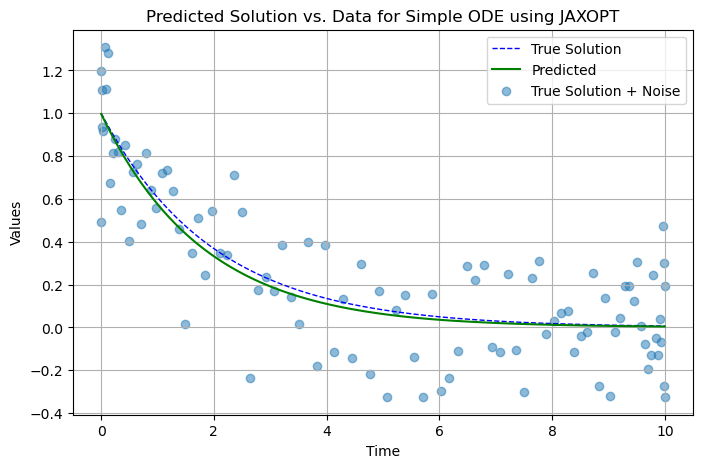

In [289]:
#---------------------------INTERPOLATION--------------------------#
interp_fn = interp1d(t, opt_u, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], 100)
y_new = interp_fn(x_new)

#---------------------------PLOT--------------------------#
plt.figure(figsize=(8, 5))

plt.subplot(1, 1, 1)  
plt.plot(t, y, 'b--', linewidth=1, label='True Solution')
plt.plot(x_new, y_new, 'g-', linewidth=1.5, label='Predicted')
plt.scatter(t, y_noisy, label='True Solution + Noise', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted Solution vs. Data for Simple ODE using JAXOPT')
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Harmonic Oscillator


$
\begin{cases}
\frac{du}{dt} = v \\
\frac{dv}{dt} = -\omega^2 u
\end{cases}
$

In [239]:
N = 100
noise_level = 0.3
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
y_noisy = np.array(jnp.squeeze(y_noisy))

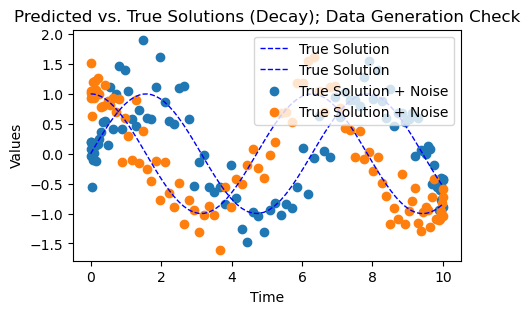

In [240]:
#--------------------------------------------VERIFY DATA--------------------------------------------#
u_noisy = y_noisy.T[0]
v_noisy = y_noisy.T[1]

plt.figure(figsize=(5, 3))

plt.subplot(1, 1, 1)  
plt.plot(t, y, 'b--', linewidth=1, label='True Solution')
plt.scatter(t, u_noisy, label='True Solution + Noise')
plt.scatter(t, v_noisy, label='True Solution + Noise')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions (Decay); Data Generation Check')
plt.legend(loc='upper right')

In [247]:
omega = params['omega_squared']

#---------------------------COLLOCATION MATRIX--------------------------#
phi = np.eye(N)
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, N-1)

#---------------------------VARIABLE DEFINITION--------------------------#
model.u = Var(model.t_idx)
model.v = Var(model.t_idx)

#---------------------------INITIAL CONDITIONS---------------------------#
# model.initial_conditions = ConstraintList()
# model.initial_conditions.add(model.u[0] == 1.0)
# model.initial_conditions.add(model.v[0] == 0.0)

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
model.ode_u = ConstraintList()
model.ode_v = ConstraintList()

for i in range(1, N):
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
    dv_dt = sum(D[i, j] * model.v[j] for j in range(N))
    
    # COLLOCATION CONSTRAINTS
    model.ode_u.add(du_dt == model.v[i])
    model.ode_v.add(dv_dt == -omega**2 * model.u[i])

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    return sum((m.u[i] - u_noisy[i])**2 + (m.v[i] - v_noisy[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=pyo.minimize)

#---------------------------SOLVING THE MODEL--------------------------#
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    19998
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      198
Total number

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 198, 'Number of variables': 200, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.16\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.041135311126708984}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [245]:
#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
v_solution = np.array([value(model.v[i]) for i in model.t_idx])

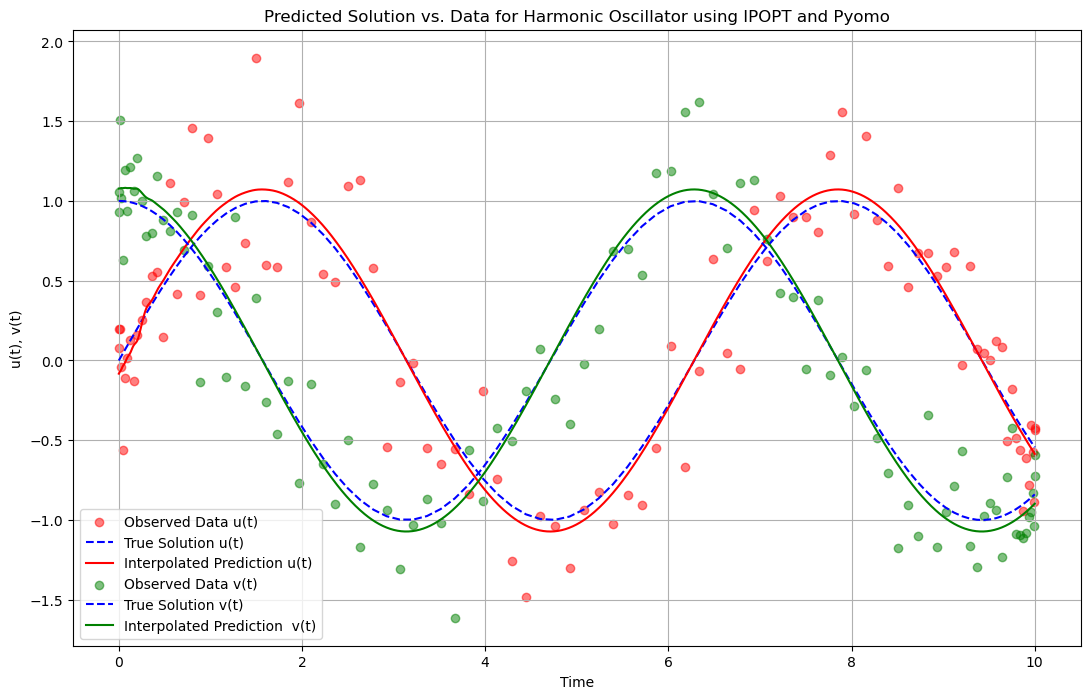

In [246]:
x_new = np.linspace(0, t[-1], 1000)

#---------------------------INTERPOLATE--------------------------#
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
u_new = interp_fn(x_new)

interp_fn = interp1d(t, v_solution, kind='cubic', fill_value='extrapolate')
v_new = interp_fn(x_new)

#---------------------------TRUE DATA--------------------------#
u_0, v_0 = 1.0, 0.0
u_correct = u_0 * jnp.cos(omega * t ) + (v_0 / omega) * jnp.sin(omega * t )
v_correct = v_0 * jnp.cos(omega * t ) - u_0 * omega * jnp.sin(omega * t )

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(13, 8))
plt.scatter(t, u_noisy, alpha = 0.5, color = "red", label='Observed Data u(t)')
plt.plot(t, y.T[0], 'b--', label='True Solution u(t)')
# plt.scatter(t, u_solution, label='Prediction u(t)')
plt.plot(x_new, u_new, 'r-', label='Interpolated Prediction u(t)')

plt.scatter(t, v_noisy, alpha = 0.5, color = "green", label='Observed Data v(t)')
plt.plot(t, y.T[1], 'b--', label='True Solution v(t)')
# plt.scatter(t, v_solution, label='Prediction v(t)')
plt.plot(x_new, v_new, 'g-', label='Interpolated Prediction  v(t)')

plt.xlabel('Time')
plt.ylabel('u(t), v(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Harmonic Oscillator using IPOPT and Pyomo')
plt.grid(True)
plt.show()

## Can we express this in the `general form`?
* This is essentially reformulating existing work, should not make any difference for the performance
* In the next steps this `ode_func` 

In [193]:
def ode_func(y, t, c = 1):
    return -c*y

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:      380
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       20

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       19
Total number

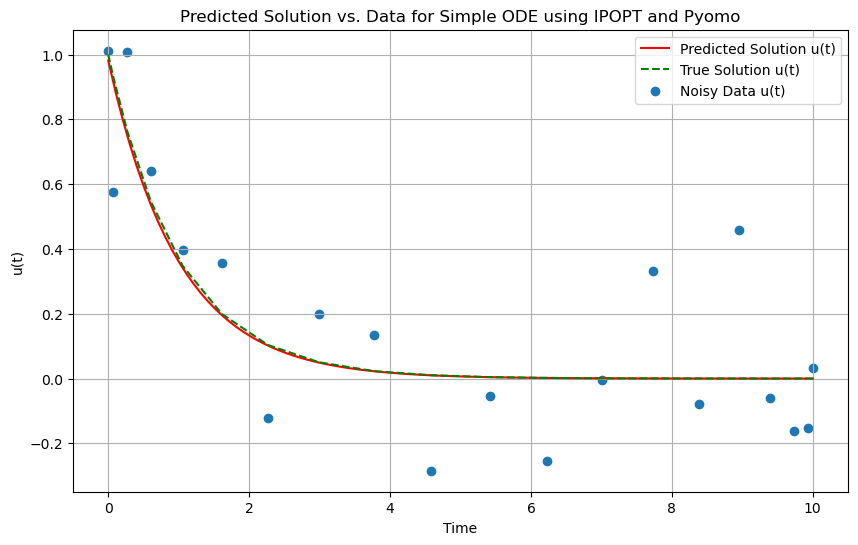

In [194]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 20
noise_level = 0.2
ode_type = "decay"
params = {"c": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, len(y_noisy)-1)

#---------------------------VARIABLE DEFINITION--------------------------#
model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
model.C = pyo.Var(domain=pyo.Reals, initialize=1.0) # adding c as a variable

#---------------------------INITIAL CONDITIONS---------------------------#
# model.initial_conditions = ConstraintList() # model.initial_conditions.add(model.u[0] == 1.0)

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
model.ode_u = ConstraintList()

# for each time point, add the ODE constraint
for i in range(1, N):
    # remains constant
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
    # approximate u????
    # u_approx = sum(model.u[j] * weights[j, i] for j in range(N+1))
    # THIS SHOUD BE A GENERIC FORMULATION TAKING IN ODE_FUNC() DEFINITION
    # model.ode_u.add(du_dt == - model.C * model.u[i])
    model.ode_u.add(du_dt == ode_func(model.u[i], t[i]))

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    return sum((m.u[i] - y_noisy[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=pyo.minimize)
    
#---------------------------SOLVING THE MODEL--------------------------#
solver = pyo.SolverFactory('ipopt')

solver.solve(model, tee=True)

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
print(f"{value(model.C):.4f}")

#---------------------------INTERPOLATION--------------------------#
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], 100)
y_new = interp_fn(x_new)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 6))
plt.plot(x_new, y_new, 'r', label='Predicted Solution u(t)')
plt.plot(t, y, 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy, label='Noisy Data u(t)')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using IPOPT and Pyomo')
plt.grid(True)
plt.show()